In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

use color to represent host and use tick to mark architecture

In [54]:
USER_START=0
USER_END=11
BASEPATH = "/Users/thl/Developer/thesis/result"
PATTERN = ["burst", "stable"][0]
ENTRY = ["single", "multiple"][0]
ARRIVAL = ["slope", "spike"][0]
FUNCTION_NAME = ["fpo-sine"][0]
ARCH_LIST = ["Centralized", "Federated", "Decentralized"]
IP_MAP = {
    "10.202.0.1": "145.100.135.86", 
    "10.202.0.2": "145.100.135.99", 
    "10.202.0.3": "192.168.100.105", 
    "10.202.0.4": "192.168.100.102", 
    "10.202.0.5": "192.168.100.103", 
    "10.202.0.6": "192.168.100.111"
}
HOSTNAME_IP_MAP = {
    "EdgeNode1 LocA": "192.168.100.105", 
    "EdgeNode2 LocA": "192.168.100.102",  
    "EdgeNode1 LocB": "192.168.100.103", 
    "EdgeNode2 LocB": "192.168.100.111", 
    "CloudNode1": "145.100.135.86", 
    "CloudNode2": "145.100.135.99"
}

In [91]:
# set theme
sns.set_theme(
    context="paper",
    style="whitegrid",
)
palette = sns.color_palette("BrBG", 6, 1)
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"]
    }
)

# Metric

In [92]:
def get_metric_dataframe(metric: str):
    dirpath = f"{BASEPATH}/{PATTERN}/{ENTRY}/{ARRIVAL}/{FUNCTION_NAME}"
    hostname_list = list(HOSTNAME_IP_MAP.keys())
    ip_list = list(HOSTNAME_IP_MAP.values())
    col_name = hostname_list + ["User Count", "Architecture"]
    user_count_list = [i for i in range(USER_START, USER_END + 1)]
    df_plot_metric = pd.DataFrame(columns = col_name)
    for user_cnt in user_count_list:
        for arch in ARCH_LIST:
            df = pd.read_csv(f"{dirpath}/{arch.lower()}/case{user_cnt}_metrics.csv")
            df["hostname"] = df["hostname"].replace(IP_MAP)
            df.index = df["hostname"]
            df = df.loc[ip_list]
            df_plot_metric.loc[len(df_plot_metric)] = list(df[metric.lower()]) + [user_cnt, arch]
            
    return df_plot_metric


In [95]:
def plot_metric_dataframe(df_plot_metric, metric, figsize = (15, 8), margin = True, ylim = True):
    # set parameter
    user_count_list = df_plot_metric["User Count"].unique()
    arch_list = df_plot_metric["Architecture"].unique()
    hostname_list = df_plot_metric.columns[:-2]
    
    # create plot
    fig, ax = plt.subplots(figsize = figsize)
    bar_width = 0.2
    legend = []
    for i, arch in enumerate(arch_list):
        bottom = np.zeros(len(user_count_list))
        for j, hostname in enumerate(hostname_list):
            metrics = df_plot_metric[df_plot_metric["Architecture"] == arch][hostname]
            offset = bar_width * i
            plot = ax.bar(
                user_count_list + offset, metrics, width = bar_width, 
                label = hostname, bottom = bottom,
                color = palette[j], edgecolor='black'
            )
            bottom += metrics
            if i == 0:
                legend.append(plot[0])

    ax.set_title(f"{metric} Utilzation of concurrent user under different architecture", fontsize="12")
    ax.set_xlabel('Concurrent User', fontsize="12")
    ax.set_ylabel(f"{metric} Utilization (\%)", fontsize="12")
            
    # concurrent user
    ax.set_xticks(list(user_count_list + bar_width), labels = [f"\n\n{i}" for i in user_count_list])
    ax.tick_params('x', length=0)

    # margin
#     ax.margins(0.15)
    if margin:
        ax.margins(y=0.15)
    if ylim:
        ymax = df_plot_metric[hostname_list].sum(axis = 1).max()*1.1
        ax.set_ylim([0, ymax])
    
    # architecture
    sec = ax.secondary_xaxis(location=0)
    sec.set_xticks(
        [ i + j * bar_width for i in user_count_list for j in range(len(arch_list))],
        labels = ['C', 'F', 'D'] * len(user_count_list)
    )
    sec.tick_params('x', length=0)
    ax.legend(legend, hostname_list, loc='upper left', ncols=len(arch_list), fontsize="12", frameon=True)
    plt.show()
#     plt.savefig("/Users/thl/Downloads/cpu.pdf")

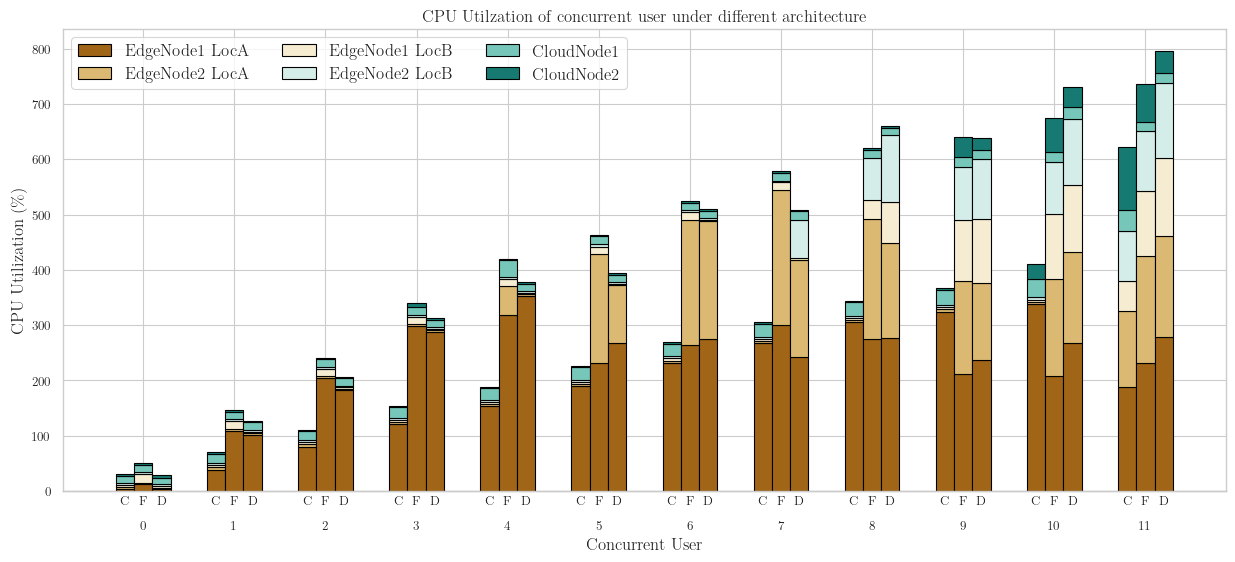

In [96]:
metric_name = "CPU"
df = get_metric_dataframe(metric_name)
plot_metric_dataframe(df, metric_name, figsize = (15, 6), margin = False, ylim = False)

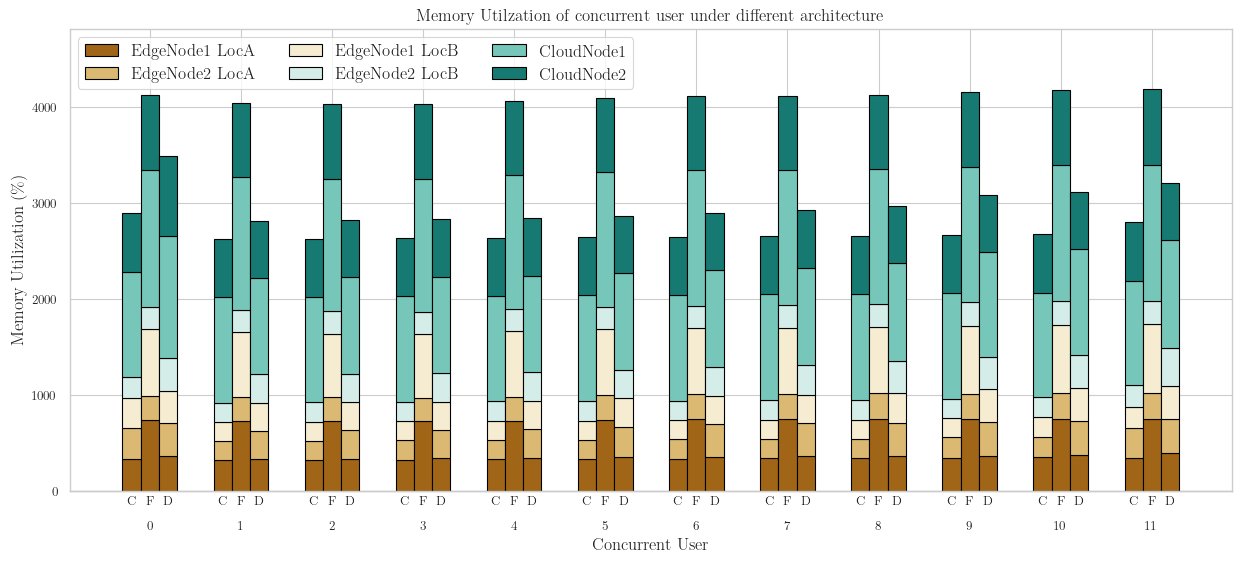

In [99]:
metric_name = "Memory"
df = get_metric_dataframe(metric_name)
plot_metric_dataframe(df, metric_name, figsize = (15, 6), margin = True, ylim = False)

https://www.codecademy.com/article/seaborn-design-ii#

# invocation count
should be similar with the resource usage
this one wil not work, as the offload will be re count

In [100]:
FUNCTION_NAME_MAP = {
    "fpo-sine": "floating-point-operation-sine.openfaas-fn"
}

In [101]:
def get_invocation_dataframe():
    dirpath = f"{BASEPATH}/{PATTERN}/{ENTRY}/{ARRIVAL}/{FUNCTION_NAME }"
    hostname_list = list(HOSTNAME_IP_MAP.keys())
    function_name = FUNCTION_NAME_MAP[FUNCTION_NAME]
    col_name = hostname_list + ["User Count", "Architecture"]
    user_count_list = [i for i in range(USER_START, USER_END + 1)]
    df_plot_invocation = pd.DataFrame(columns = col_name)
    for user_cnt in user_count_list:
        for arch in ARCH_LIST:
            df = pd.read_csv(f"{dirpath}/{arch.lower()}/case{user_cnt}_invocation_count.csv")
            df = df[df["function_name"] == function_name]
            df.index = df["hostname"]
            row_cnt = len(df_plot_invocation)
            df_plot_invocation.loc[row_cnt, ["User Count", "Architecture"]] = [user_cnt, arch]
            for hostname in hostname_list:
                ip = HOSTNAME_IP_MAP[hostname]
                try:
                    df_plot_invocation.loc[row_cnt, hostname] = df.loc[ip, "invocation"]
                except:
                    df_plot_invocation.loc[row_cnt, hostname] = 0
    df_plot_invocation[hostname_list] = df_plot_invocation[hostname_list].astype('int')
    return df_plot_invocation

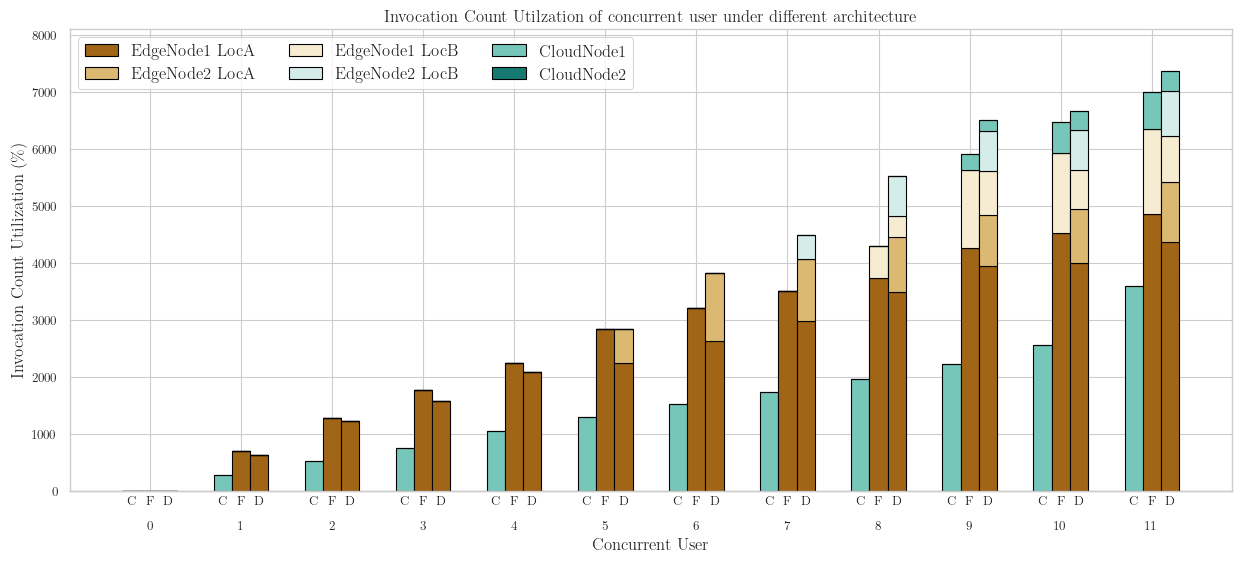

In [102]:
metric_name = "Invocation Count"
df = get_invocation_dataframe()
plot_metric_dataframe(df, metric_name, figsize = (15, 6), margin = False, ylim = True)